### Abrindo o vídeo e mostrando o vídeo

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib.use('TkAgg')
#removido para a plotagem dos gráficos
import imageio
from IPython import display
from time import sleep
import matplotlib.pyplot as plt

import pims
from PIL import Image

imageio.plugins.ffmpeg.download()

v = pims.Video('../dataset/25_20160407_front/normal/crowd/2016_04_07_06_49_39FrontColor.avi')

In [10]:
def play(video):
    
    fig = plt.figure()
    ax = fig.gca()
    fig.show()

    for ii in range(len(video)):
        im = video[ii]
        plt.imshow(im, cmap='gray')
        ax.set_title(ii)

        fig.canvas.draw()
        sleep(0.1)

Algumas informações sobre o vídeo aberto:

In [11]:
print(v.get_metadata())

v_array = np.array(v)
print('\n', v_array.shape)

{'plugin': 'ffmpeg', 'nframes': 322, 'ffmpeg_version': 'N-86111-ga441aa90e8-static http://johnvansickle.com/ffmpeg/ built with gcc 5.4.1 (Debian 5.4.1-8) 20170304', 'fps': 25.0, 'source_size': (320, 240), 'size': (320, 240), 'duration': 12.88}

 (322, 240, 320, 3)


Os campos da *tupla* anterior significam o seguinte:
(Frames, Altura, Largura, Cores)

### Convertendo o vídeo para escala de cinza

In [12]:
def to_gray(video):
    frames, width, hight, color = video.shape
    video_gray = np.zeros((frames, width, hight), dtype='uint32')
    
    for ii in range(len(video)):
        r, g, b = Image.fromarray(video[ii]).split()
        
        r = np.array(r, dtype='uint32')
        g = np.array(g, dtype='uint32')
        b = np.array(b, dtype='uint32')
        
        video_gray[ii] = (r + g + b) / 3
        
    return video_gray

In [13]:
x = to_gray(v_array)
#play(x[0:30])

In [14]:
x_cropped=x[:,100:240,0:150]
#play(x_cropped[0:30])

In [15]:
def integra(x):
    s=np.sum(x,axis=1)
    s=np.sum(s,axis=1)
    return s

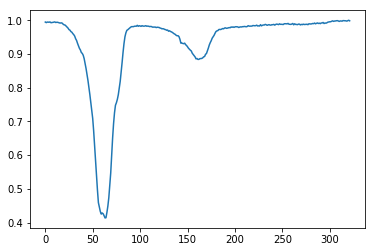

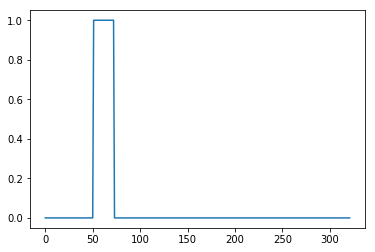

In [22]:
integral=integra(x_cropped)
integral=integral/np.max(integral)
plt.plot(integral)
plt.show();
peaks=integral<0.7
plt.plot(info)
plt.show();